# Analyzing SubClusters of Mutant and Wild-type Clones

**Gregory Way, 2019**

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(magrittr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggrepel))
suppressPackageStartupMessages(library(cowplot))

In [2]:
set.seed(0112)

In [3]:
con <- curl::curl("https://raw.githubusercontent.com/broadinstitute/cytominer_scripts/master/write_gct.R")
source(con)

In [4]:
util_file <- file.path("..", "scripts", "processing_utils.R")
source(util_file)

viz_file <- file.path("..", "scripts", "visualization_utils.R")
source(viz_file)

In [5]:
file <- file.path("..", "data", "2019_06_25_Batch3_merged_intersected_variable_selected.csv")
data_df <- load_data(file)

print(dim(data_df))
head(data_df, 3)

[1] 105 191


Metadata_Plate,Metadata_Well,Metadata_Assay_Plate_Barcode,Metadata_Plate_Map_Name,Metadata_well_position,Metadata_clone_number,Cells_AreaShape_Compactness,Cells_AreaShape_EulerNumber,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,⋯,Nuclei_Texture_Correlation_AGP_20_00,Nuclei_Texture_Correlation_AGP_20_03,Nuclei_Texture_Correlation_AGP_5_00,Nuclei_Texture_Correlation_ER_20_02,Nuclei_Texture_Correlation_Mito_5_00,Nuclei_Texture_Correlation_RNA_20_02,Nuclei_Texture_InfoMeas1_Mito_5_00,Nuclei_Texture_InverseDifferenceMoment_AGP_20_02,Nuclei_Texture_InverseDifferenceMoment_DNA_20_03,Nuclei_Texture_InverseDifferenceMoment_ER_20_02
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MutClones,B02,MutClones,MutClones,B02,BZ001,0.6034418,-3.057030,0.05068862,0.6585738,⋯,3.3582920,1.126295,0.000000,1.204256,0.42066821,0.5705776,-1.320394,-0.2247533,1.311671,0.212493
MutClones,B03,MutClones,MutClones,B03,BZ002,-1.0295421,-1.419110,1.11426953,-0.9345095,⋯,-0.3068762,1.536572,-4.293160,3.379792,-6.81572415,0.4181798,3.899485,2.1667509,2.502230,2.646517
MutClones,B04,MutClones,MutClones,B04,BZ003,1.6599068,-1.161031,-1.71337361,-0.2834930,⋯,4.4402692,1.169331,2.445327,4.378964,0.08634202,0.9786170,-2.408064,-0.1248563,0.000000,1.157526


## Apply kmeans to identify evenly sized clusters

In [6]:
feature_df <- data_df %>% dplyr::select(-starts_with("Metadata_"))

cor_mat <- cor(t(feature_df), method = "pearson")
dist_mat <- as.dist(cor_mat)
kmeans_result <- kmeans(dist_mat, centers = 4)

In [7]:
data_df <- data_df %>%
    dplyr::mutate(Metadata_cluster_groups = paste(kmeans_result$cluster))

In [8]:
table(kmeans_result$cluster)


 1  2  3  4 
14 25 34 32 

## Save Cluster Assignments

In [9]:
gct_file <- file.path("results", "kmeans_batch3_group.gct")
write_gct(data_df, gct_file)

Warning message:
“select_() is deprecated. 
Please use select() instead

The 'programming' vignette or the tidyeval book can help you
to program with select() : https://tidyeval.tidyverse.org
This warning is displayed once per session.”Warning message:
“`data_frame()` is deprecated, use `tibble()`.
This warning is displayed once per session.”

In [10]:
tstat_group <- c()
pval_group <- c()
subgroup_vector <- c()
feature_vector <- c()
shuffle_vector <- c()

for (subgroup in unique(data_df$Metadata_cluster_groups)) {
    
    data_subset_df <- data_df %>%
        dplyr::filter(Metadata_cluster_groups == !!subgroup)
    
    for (feature in colnames(data_subset_df)) {

        if (!grepl("Metadata_", feature)) {
            
            for (shuffle in c("no_shuffle", "shuffle")) {
                
                if (shuffle == "shuffle") {
                    data_subset_copy_df <- data_subset_df
                    data_subset_copy_df$Metadata_Plate <- sample(data_subset_copy_df$Metadata_Plate)
                } else {
                    data_subset_copy_df <- data_subset_df
                }
                # Perform Cell Line Experiment at 0.7uM Dose
                resistant_clones <- data_subset_copy_df %>%
                    dplyr::filter(Metadata_Plate == "MutClones") %>%
                    dplyr::pull(!!feature)

                wt_cells <- data_subset_copy_df %>%
                    dplyr::filter(Metadata_Plate == "WTClones") %>%
                    dplyr::pull(!!feature)

                result <- t.test(resistant_clones, wt_cells, var.equal = FALSE)

                tstat_group <- c(tstat_group, as.numeric(paste(result$statistic)))
                pval_group <- c(pval_group, result$p.value)
                subgroup_vector <- c(subgroup_vector, subgroup)
                feature_vector <- c(feature_vector, feature)
                shuffle_vector <- c(shuffle_vector, shuffle)
            }
            
        }
    } 
}

In [11]:
result_df <- as.data.frame(cbind(tstat_group, pval_group, subgroup_vector, feature_vector, shuffle_vector))

result_df$tstat_group <- as.numeric(paste(result_df$tstat_group))
result_df$pval_group <- as.numeric(paste(result_df$pval_group))
result_df$neglog10p <- -log10(result_df$pval_group)

result_file <- file.path("results", "subgroup_ttest_results.tsv")
result_df %>% readr::write_tsv(result_file)

head(result_df, 3)

tstat_group,pval_group,subgroup_vector,feature_vector,shuffle_vector,neglog10p
<dbl>,<dbl>,<fct>,<fct>,<fct>,<dbl>
3.4866541,0.003251478,2,Cells_AreaShape_Compactness,no_shuffle,2.4879192
0.4526949,0.655075784,2,Cells_AreaShape_Compactness,shuffle,0.1837085
0.6056639,0.556852196,2,Cells_AreaShape_EulerNumber,no_shuffle,0.2542601


## Save a Series of Figures

In [12]:
yintercept = -log10(0.05 / (dim(result_df)[1] / 2))
yintercept

[1] 4.170262

In [13]:
repel_logic <- result_df$neglog10p > yintercept * 1.4

In [14]:
subcluster_colors <- c("1" = "#d3aa5a",
                       "2" = "#1d6dab",
                       "3" = "#a9da7f", 
                       "4" = "#2e9627")

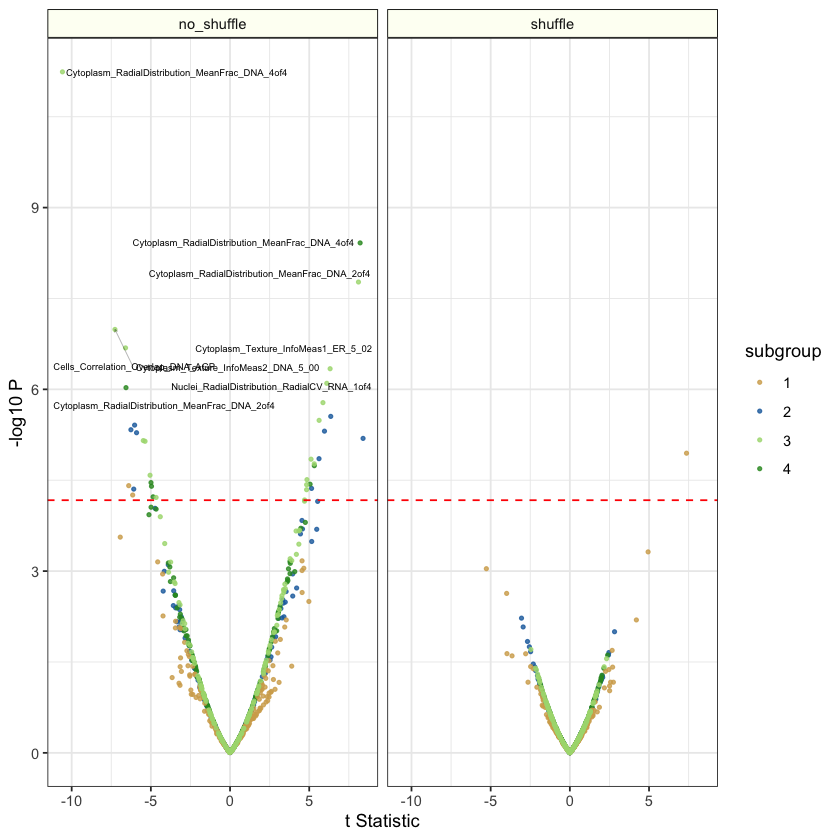

In [15]:
volcano_gg <- ggplot(result_df,
       aes(x = tstat_group,
           y = neglog10p)) +
    geom_point(aes(color = subgroup_vector),
               alpha = 0.8,
               size = .8) +
    geom_hline(yintercept = yintercept,
               color = "red",
               linetype = "dashed") +
    xlab("t Statistic") +
    ylab("-log10 P") +
    facet_wrap(~shuffle_vector) +
    scale_color_manual(name = "subgroup",
                       values = subcluster_colors,
                       labels = c("1" = "1", 
                                  "2" = "2",
                                  "3" = "3",
                                  "4" = "4")) +
    geom_text_repel(data = subset(result_df, repel_logic),
                    arrow = arrow(length = unit(0.01, "npc")),
                    size = 2,
                    segment.size = 0.1,
                    segment.alpha = 0.8,
                    force = 20,
                    aes(x = tstat_group,
                        y = neglog10p,
                        label = feature_vector)) +
    theme_bw() +
    theme(strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4"))

file_base <- file.path("figures", "subcluster_volcano_plot")
save_figure(volcano_gg, file_base, height = 6, width = 12)

volcano_gg

In [16]:
result_df$mutant_high <- as.integer(result_df$tstat_group > 0)

sorted_result_df <- result_df %>%
    dplyr::group_by(feature_vector, shuffle_vector) %>%
    dplyr::mutate(feature_sum = sum(neglog10p),
                  same_direction_tstat = sum(mutant_high)) %>%
    dplyr::arrange(desc(feature_sum)) %>%
    dplyr::ungroup()

sorted_result_df$feature_vector <- factor(sorted_result_df$feature_vector,
                                          levels = unique(sorted_result_df$feature_vector))


head(sorted_result_df, 10)

tstat_group,pval_group,subgroup_vector,feature_vector,shuffle_vector,neglog10p,mutant_high,feature_sum,same_direction_tstat
<dbl>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<int>,<dbl>,<int>
-5.903778,5.199900e-06,2,Cytoplasm_RadialDistribution_MeanFrac_DNA_4of4,no_shuffle,5.2840050,0,25.42062,2
8.214661,3.827179e-09,4,Cytoplasm_RadialDistribution_MeanFrac_DNA_4of4,no_shuffle,8.4171213,1,25.42062,2
1.150214,3.318423e-01,1,Cytoplasm_RadialDistribution_MeanFrac_DNA_4of4,no_shuffle,0.4790682,1,25.42062,2
-10.583228,5.748811e-12,3,Cytoplasm_RadialDistribution_MeanFrac_DNA_4of4,no_shuffle,11.2404219,0,25.42062,2
5.147620,4.316894e-05,2,Cytoplasm_RadialDistribution_MeanFrac_DNA_2of4,no_shuffle,4.3648286,1,19.20350,2
-6.570483,9.374174e-07,4,Cytoplasm_RadialDistribution_MeanFrac_DNA_2of4,no_shuffle,6.0280670,0,19.20350,2
-1.861336,9.135858e-02,1,Cytoplasm_RadialDistribution_MeanFrac_DNA_2of4,no_shuffle,1.0392507,0,19.20350,2
8.109635,1.692954e-08,3,Cytoplasm_RadialDistribution_MeanFrac_DNA_2of4,no_shuffle,7.7713549,1,19.20350,2
-3.128081,6.745695e-03,2,Cytoplasm_Texture_InfoMeas2_DNA_5_00,no_shuffle,2.1709733,0,16.09358,2


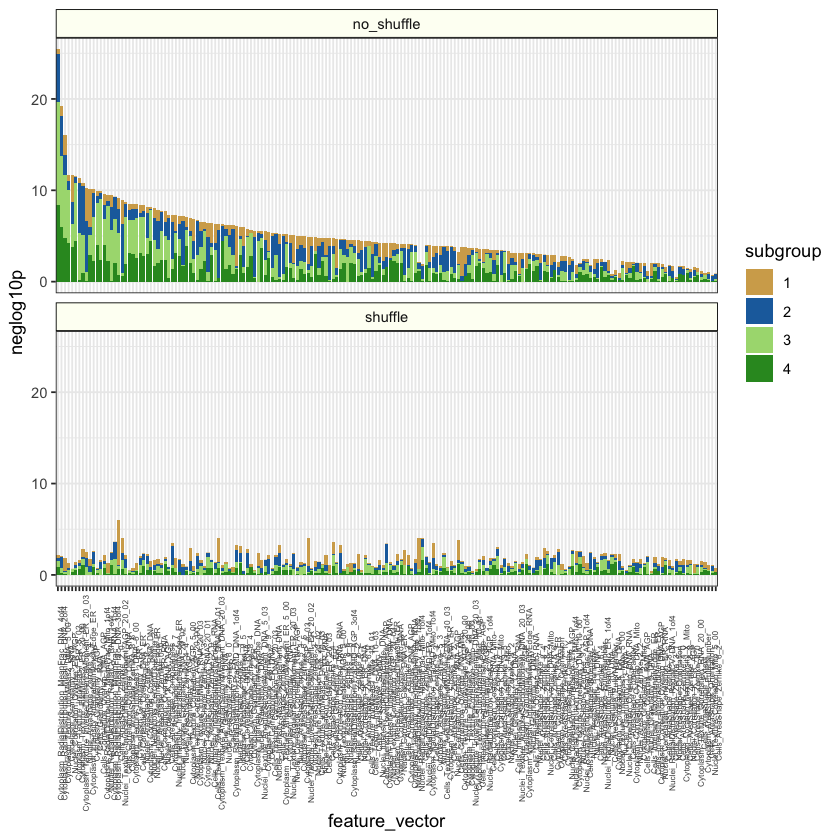

In [17]:
all_feature_gg <- ggplot(sorted_result_df,
       aes(x = feature_vector,
           y = neglog10p)) +
    geom_bar(aes(fill = subgroup_vector), stat="identity") +
    theme_bw() + 
    facet_wrap(~shuffle_vector, ncol = 1) +
    theme(axis.text.x = element_text(size = 5, angle = 90),
          strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4")) +
    scale_fill_manual(name = "subgroup",
                       values = subcluster_colors,
                       labels = c("1" = "1", 
                                  "2" = "2",
                                  "3" = "3",
                                  "4" = "4"))

file_base <- file.path("figures", "subcluster_all_feature_barchart")
save_figure(all_feature_gg, file_base, height = 10, width = 12)

all_feature_gg

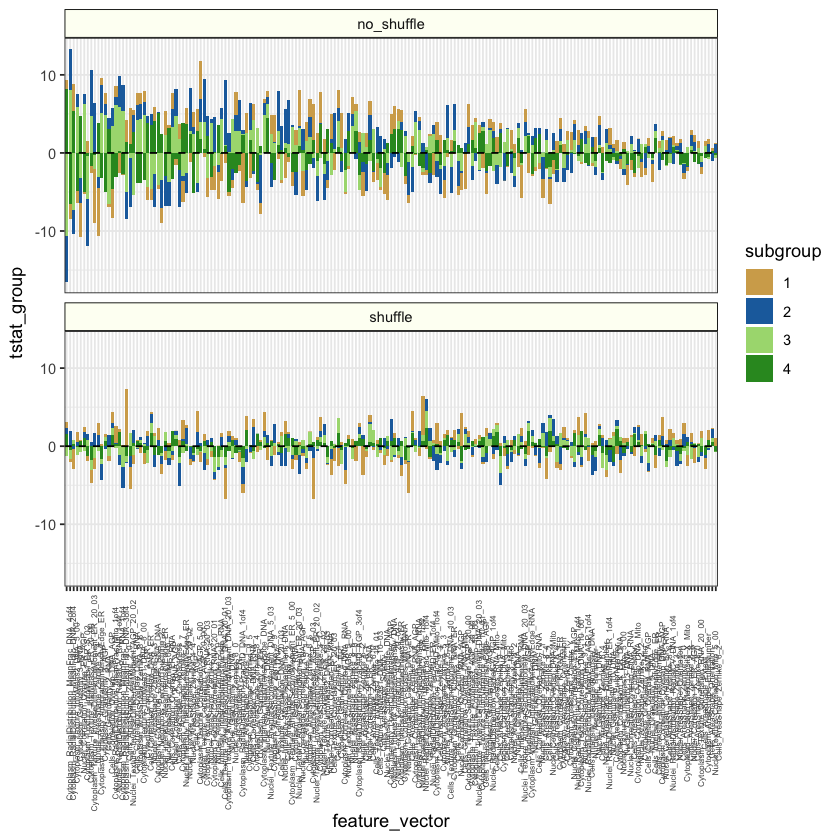

In [18]:
all_tstat_feature_gg <- ggplot(sorted_result_df,
       aes(x = feature_vector,
           y = tstat_group)) +
    geom_bar(aes(fill = subgroup_vector), stat="identity") +
    theme_bw() + 
    theme(axis.text.x = element_text(size = 5, angle = 90),
          strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4")) +
    facet_wrap(~shuffle_vector, ncol = 1) +
    scale_fill_manual(name = "subgroup",
                       values = subcluster_colors,
                       labels = c("1" = "1", 
                                  "2" = "2",
                                  "3" = "3",
                                  "4" = "4")) +
    geom_hline(yintercept = 0,
                   linetype = "dashed",
                   lwd = 0.5)

file_base <- file.path("figures", "subcluster_all_feature_barchart_tstat")
save_figure(all_tstat_feature_gg, file_base, height = 6, width = 12)

all_tstat_feature_gg

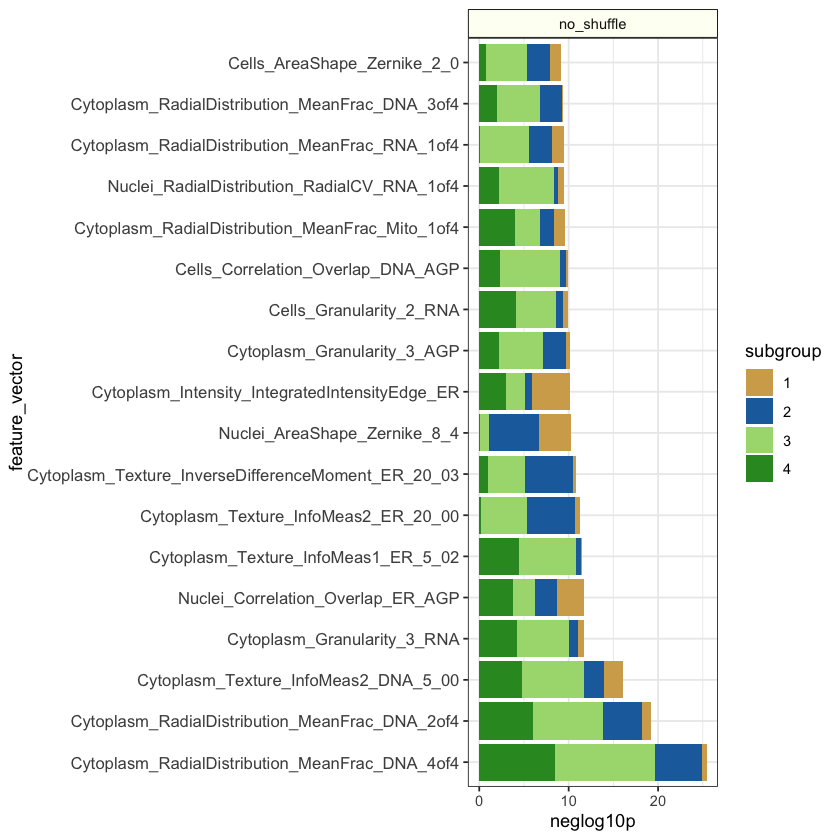

In [19]:
top_result_df <- sorted_result_df %>%
    dplyr::filter(feature_sum > 9)

top_feature_gg <- ggplot(top_result_df,
       aes(x = feature_vector,
           y = neglog10p)) +
    geom_bar(aes(fill = subgroup_vector), stat="identity") +
    theme_bw() + 
    facet_wrap(~shuffle_vector, nrow = 1) +
    theme(axis.text.y = element_text(size = 10, angle = 0),
          strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4")) +
    scale_fill_manual(name = "subgroup",
                       values = subcluster_colors,
                       labels = c("1" = "1", 
                                  "2" = "2",
                                  "3" = "3",
                                  "4" = "4")) +
    coord_flip()

file_base <- file.path("figures", "subcluster_top_feature_barchart")
save_figure(top_feature_gg, file_base, height = 6, width = 9)

top_feature_gg

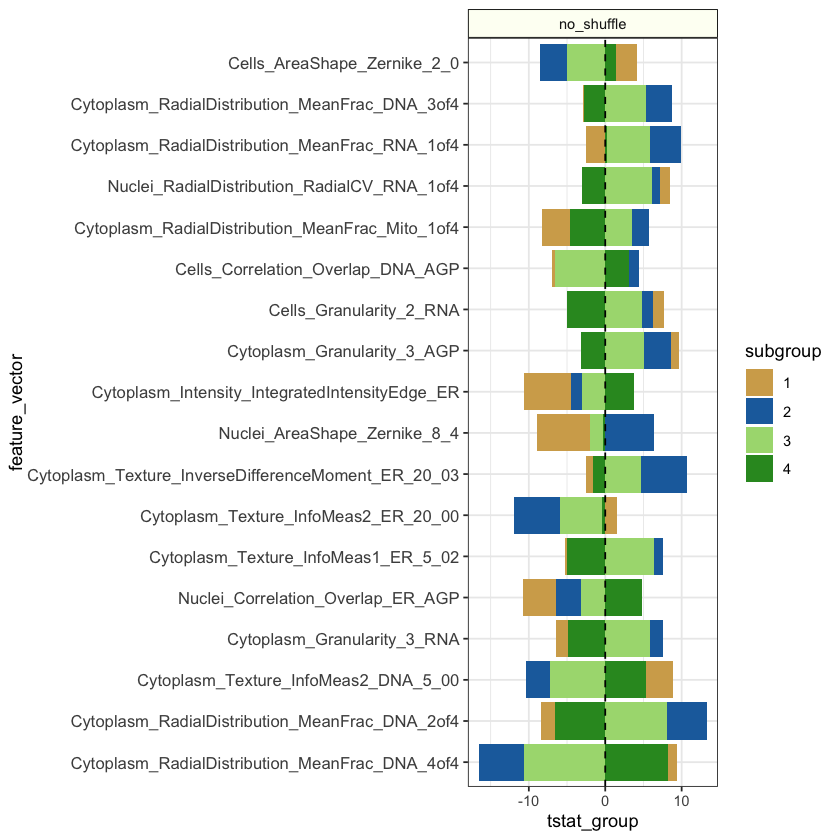

In [20]:
tstat_feature_gg <- ggplot(top_result_df,
       aes(x = feature_vector,
           y = tstat_group)) +
    geom_bar(aes(fill = subgroup_vector), stat="identity") +
    theme_bw() + 
    facet_wrap(~shuffle_vector, nrow = 1) +
    theme(axis.text.y = element_text(size = 10, angle = 0),
          strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4")) +
    scale_fill_manual(name = "subgroup",
                      values = subcluster_colors,
                      labels = c("1" = "1", 
                                  "2" = "2",
                                  "3" = "3",
                                  "4" = "4")) +
    geom_hline(yintercept = 0,
               linetype = "dashed",
               lwd = 0.5) +
    coord_flip()

file_base <- file.path("figures", "subcluster_top_feature_barchart_tstat")
save_figure(tstat_feature_gg, file_base, height = 6, width = 9)

tstat_feature_gg

In [21]:
same_direction_df <- sorted_result_df %>%
    dplyr::filter(same_direction_tstat %in% c(0, 4))

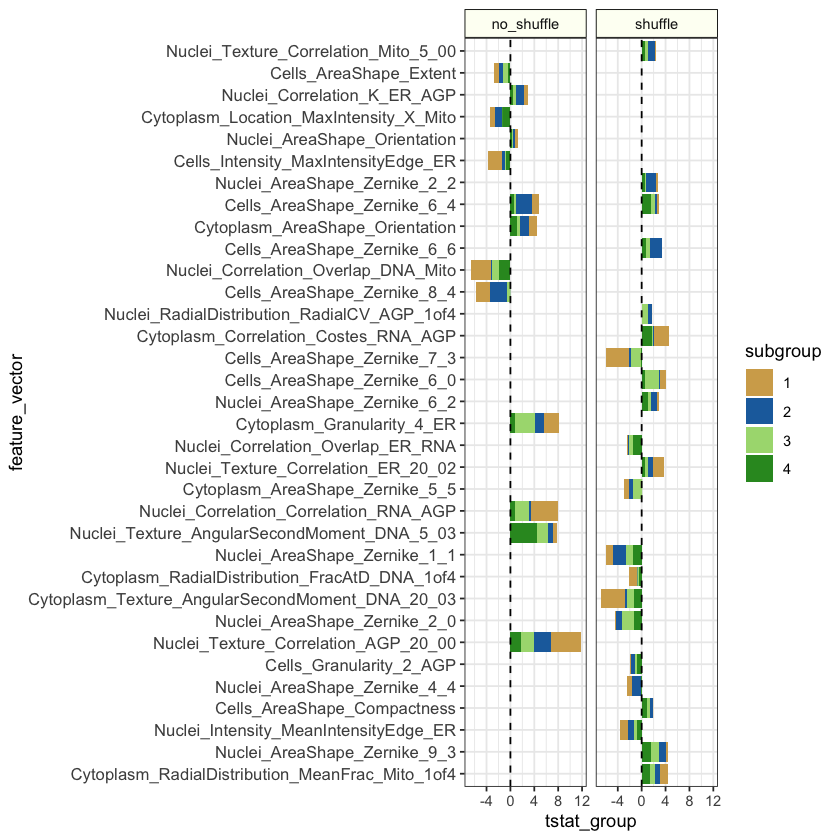

In [22]:
tstat_feature_same_direction_gg <- ggplot(same_direction_df,
       aes(x = feature_vector,
           y = tstat_group)) +
    geom_bar(aes(fill = subgroup_vector), stat="identity") +
    theme_bw() + 
    facet_wrap(~shuffle_vector, nrow = 1) +
    theme(axis.text.y = element_text(size = 10, angle = 0),
          strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4")) +
    scale_fill_manual(name = "subgroup",
                       values = subcluster_colors,
                       labels = c("1" = "1", 
                                  "2" = "2",
                                  "3" = "3",
                                  "4" = "4")) +
    geom_hline(yintercept = 0,
               linetype = "dashed",
               lwd = 0.5) +
    coord_flip()

file_base <- file.path("figures", "subcluster_top_feature_barchart_tstat_samedirection")
save_figure(tstat_feature_same_direction_gg, file_base, height = 6, width = 9)

tstat_feature_same_direction_gg